In [1]:
import random
import numpy as np
from statistics import mean
from random import randrange
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import sys
from scipy.spatial import distance
%matplotlib inline

## Load Data

load both train and test data

In [140]:
train_small = np.genfromtxt(
        'datasets/MNIST_train_small.csv', delimiter=',')
test_small = np.genfromtxt('datasets/MNIST_test_small.csv', delimiter=',')

In [141]:
X_train_small, y_train_small, X_test_small, y_test_small = train_small[:,1:], train_small[:,0], test_small[:,1:], test_small[:,0]

## K-Nearest Neighbor

In [142]:
class KNearestNeighbors():
    """ K-nearest neighbour aka KNN classifier
    
    Parameters
    -------------
    k : int classes
    p : int parameter p in Minkowski Distance calculation
    
    Attributes
    -------------
    
    """
    
    # initialize parameters in KNN model
    def __init__(self, k, p=2):
        self.k = k
        self.p = p    
    
    def compute_distance(self, X_test):
#         distances = np.sqrt(np.sum(X_test**2, axis=1, keepdims=True) + np.sum(X_train**2, axis=1, keepdims=True).T - 2*np.dot(X_test, X_train.T))
        distances=distance.cdist(X_test,self.X_train,'minkowski', p = self.p)
        return distances
    
#     def compute_distance(self, X_test):
#         num_test = X_test.shape[0]
#         num_train = self.X_train.shape[0]
#         distances = np.zeros((num_test, num_train))

#         for i in range(num_test):
#             for j in range(num_train):
#                 distances[i, j] = np.sum(np.absolute(X_test[i,:] - self.X_train[j,:])**self.p)**(self.p**-1)
#         return distances
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        
        #compute distances between 
        distances = self.compute_distance(X_test)
        
        #generate predictions
        n_test = distances.shape[0]
        y_pred = np.zeros(n_test)
        for i in range(n_test):
            y_index = np.argsort(distances[i, :])
            k_closests = self.y_train[y_index[:self.k]].astype(int)
            y_pred[i] = np.argmax(np.bincount(k_closests))
        return y_pred
        

## a. Using Euclidean distance to plot empirical training and test loss as a function of k

In [5]:
k_neighbors = np.linspace(1, 20, 20, dtype='int')

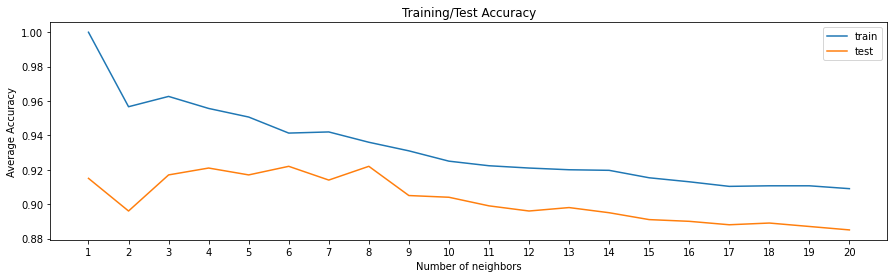

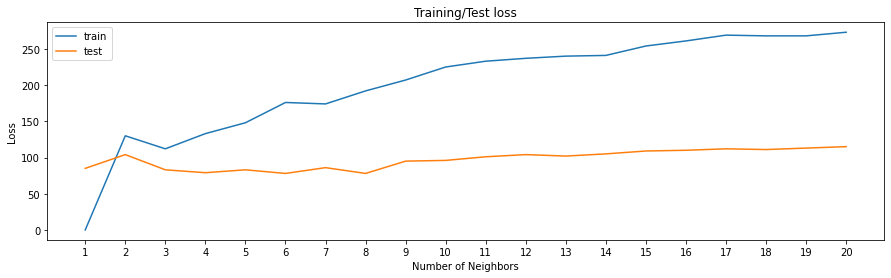

In [250]:
plt.figure(figsize=(15,4))
plt.title("Training/Test Accuracy")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
train_acc_results = []
test_acc_results = []
train_loss_results = []
test_loss_results = []
for k in k_neighbors:
    KNN = KNearestNeighbors(k,2)
    KNN.fit(X_train_small,y_train_small)
    y_train_pred = KNN.predict(X_train_small)
    y_test_pred = KNN.predict(X_test_small)
    train_acc = np.sum(y_train_pred == y_train_small)/y_train_small.shape[0]
    test_acc = np.sum(y_test_pred == y_test_small)/y_test_small.shape[0]
    train_loss = np.sum(y_train_pred!=y_train_small)
    test_loss = np.sum(y_test_pred!=y_test_small)
    train_loss_results.append(train_loss)
    test_loss_results.append(test_loss)
    train_acc_results.append(train_acc)
    test_acc_results.append(test_acc)
    
plt.plot(k_neighbors,train_acc_results,label='train')
plt.plot(k_neighbors,test_acc_results,label='test')
plt.legend()
plt.show()

plt.figure(figsize=(15,4))
plt.title("Training/Test loss")
plt.ylabel("Loss")
plt.xlabel("Number of Neighbors")
plt.xticks(k_neighbors)
plt.plot(k_neighbors,train_loss_results,label='train')
plt.plot(k_neighbors,test_loss_results,label='test')
plt.legend()
plt.show()

## Cross Validation with KNN

An alternative way is to return indices, instead of k folds. Apart from this, we do not have to randomly pick data from dataset since the original dataset is sampled randomly. Hence, any randomly picked subset of the original dataset is random. The only thing we may have to do is to shuffle the data, since we are not sure what is the order of collected data.

In [6]:
import sys
def cross_val_score(X, y , cv=5, k=5, p=2):
    fold_size = int(y.shape[0]/cv)
    indices = np.arange(y.shape[0])
    np.random.RandomState(123).shuffle(indices)
    result = []
    KNN = KNearestNeighbors(k = k, p = p)
    for i in range(cv):
        validation_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        KNN.fit(X[train_idx], y[train_idx])
        y_pred = KNN.predict(X[validation_idx])
        valid_acc = np.sum(y_pred == y[validation_idx])
        result.append(valid_acc/validation_idx.shape[0])
    
    return result

### b&c Implement LOOCV to estimate the rick of the k-NN rule for k and p $\in\{1,...,20\}$

In [8]:
def leave_one_out(X, y, k, p, pdist):
    n_samples = y.shape[0]
    indices = np.arange(n_samples)
    np.random.RandomState(123).shuffle(indices)
    count = 0
    for i in range(n_samples):
        y_index = np.argsort(pdist[i])
        k_closests = y[y_index[1:k+1]].astype(int)
        if np.argmax(np.bincount(k_closests)) == y[i]: count += 1 
    return count / n_samples

In [9]:
def new_cross_val_score(X, y, distances, cv=5, k=5, p=2):
    fold_size = int(y.shape[0]/cv)
    indices = np.arange(y.shape[0])
    np.random.RandomState(123).shuffle(indices)
    result = np.array([])
    for i in range(cv):
        validation_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        n_test = distances[validation_idx].shape[0]
        y_pred = np.zeros(n_test)
        for j in range(n_test):
            y_index = np.argsort(distances[validation_idx][j,train_idx])
            k_closests = y[train_idx][y_index[:k]].astype(int)
            y_pred[j] = np.argmax(np.bincount(k_closests))
        
        valid_acc = np.sum(y_pred == y[validation_idx])
        result = np.append(result,valid_acc/validation_idx.shape[0])
    
    return result

In [195]:
def new_new_cross_val_score(X, y, distances, cv=5, k=5, p=2):
    fold_size = int(y.shape[0]/cv)
    indices = np.arange(y.shape[0])
    np.random.RandomState(123).shuffle(indices)
    result = np.array([])
    for i in range(cv):
        validation_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        
        y_indices = np.argsort(distances[validation_idx][:,train_idx])
        k_closests = y[train_idx][y_indices[:,:k]].astype(int)
        bincount = np.array([np.count_nonzero(k_closests == j, axis = 1) for j in range(10)]).transpose()
        y_pred = np.argmax(bincount,axis = 1)
        
        valid_acc = np.sum(y_pred == y[validation_idx])
        result = np.append(result,valid_acc/validation_idx.shape[0])
    
    return result

In [148]:
k_neighbors = np.linspace(1, 20, 20, dtype='int')

In [143]:
distances = distance.pdist(X_train_small, 'minkowski', 2)
distances = distance.squareform(distances)

start validate 1  neighbors

finished, mean accuracy: 0.9193333333333333
start validate 2  neighbors

finished, mean accuracy: 0.9113333333333333
start validate 3  neighbors

finished, mean accuracy: 0.9213333333333333
start validate 4  neighbors

finished, mean accuracy: 0.921
start validate 5  neighbors

finished, mean accuracy: 0.92
start validate 6  neighbors

finished, mean accuracy: 0.917
start validate 7  neighbors

finished, mean accuracy: 0.9166666666666666
start validate 8  neighbors

finished, mean accuracy: 0.9106666666666666
start validate 9  neighbors

finished, mean accuracy: 0.9123333333333333
start validate 10  neighbors

finished, mean accuracy: 0.91
start validate 11  neighbors

finished, mean accuracy: 0.908
start validate 12  neighbors

finished, mean accuracy: 0.9056666666666666
start validate 13  neighbors

finished, mean accuracy: 0.905
start validate 14  neighbors

finished, mean accuracy: 0.9056666666666666
start validate 15  neighbors

finished, mean accuracy

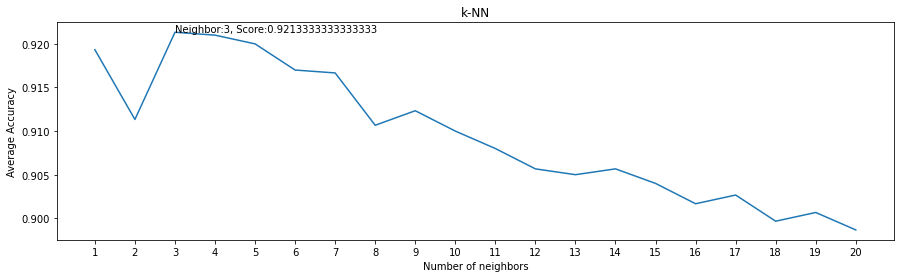

In [194]:
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
results = []
bn, bs = 0, 0
for k in k_neighbors:
    # k-fold cv from scratch for k-NN
    print("start validate", k," neighbors")
    acc = mean(new_new_cross_val_score(X_train_small, y_train_small, distances, cv=y_train_small.shape[0], k=k, p=2))
    results.append(acc)
    print("\nfinished, mean accuracy:",acc)
    if (bs < acc): 
        bn, bs = k, acc
plt.text(bn, bs, f'Neighbor:{bn}, Score:{bs}')
plt.plot(k_neighbors, results)
plt.show()

In [12]:
k_neighbors = np.linspace(1, 20, 20, dtype='int')
n_powers = np.linspace(1,15,15,dtype = 'int')

Start validation: P:1, K:1
Finished, mean accuracy: 91.033%
Start validation: P:1, K:2
Finished, mean accuracy: 89.967%
Start validation: P:1, K:3
Finished, mean accuracy: 90.633%
Start validation: P:1, K:4
Finished, mean accuracy: 90.833%
Start validation: P:1, K:5
Finished, mean accuracy: 90.367%
Start validation: P:1, K:6
Finished, mean accuracy: 90.367%
Start validation: P:1, K:7
Finished, mean accuracy: 90.167%
Start validation: P:1, K:8
Finished, mean accuracy: 90.333%
Start validation: P:1, K:9
Finished, mean accuracy: 90.033%
Start validation: P:1, K:10
Finished, mean accuracy: 89.700%
Start validation: P:1, K:11
Finished, mean accuracy: 89.767%
Start validation: P:1, K:12
Finished, mean accuracy: 89.667%
Start validation: P:1, K:13
Finished, mean accuracy: 89.533%
Start validation: P:1, K:14
Finished, mean accuracy: 89.367%
Start validation: P:1, K:15
Finished, mean accuracy: 88.933%
Start validation: P:1, K:16
Finished, mean accuracy: 88.900%
Start validation: P:1, K:17
Finis

Finished, mean accuracy: 91.733%
Start validation: P:7, K:17
Finished, mean accuracy: 91.500%
Start validation: P:7, K:18
Finished, mean accuracy: 91.700%
Start validation: P:7, K:19
Finished, mean accuracy: 91.567%
Start validation: P:7, K:20
Finished, mean accuracy: 91.267%
Start validation: P:8, K:1
Finished, mean accuracy: 93.067%
Start validation: P:8, K:2
Finished, mean accuracy: 92.433%
Start validation: P:8, K:3
Finished, mean accuracy: 93.733%
Start validation: P:8, K:4
Finished, mean accuracy: 93.467%
Start validation: P:8, K:5
Finished, mean accuracy: 93.200%
Start validation: P:8, K:6
Finished, mean accuracy: 92.767%
Start validation: P:8, K:7
Finished, mean accuracy: 92.767%
Start validation: P:8, K:8
Finished, mean accuracy: 92.433%
Start validation: P:8, K:9
Finished, mean accuracy: 92.433%
Start validation: P:8, K:10
Finished, mean accuracy: 92.767%
Start validation: P:8, K:11
Finished, mean accuracy: 92.367%
Start validation: P:8, K:12
Finished, mean accuracy: 92.500%


Finished, mean accuracy: 92.700%
Start validation: P:14, K:11
Finished, mean accuracy: 92.600%
Start validation: P:14, K:12
Finished, mean accuracy: 92.933%
Start validation: P:14, K:13
Finished, mean accuracy: 92.367%
Start validation: P:14, K:14
Finished, mean accuracy: 92.433%
Start validation: P:14, K:15
Finished, mean accuracy: 92.067%
Start validation: P:14, K:16
Finished, mean accuracy: 91.967%
Start validation: P:14, K:17
Finished, mean accuracy: 91.733%
Start validation: P:14, K:18
Finished, mean accuracy: 91.633%
Start validation: P:14, K:19
Finished, mean accuracy: 91.500%
Start validation: P:14, K:20
Finished, mean accuracy: 91.333%
Start validation: P:15, K:1
Finished, mean accuracy: 92.967%
Start validation: P:15, K:2
Finished, mean accuracy: 92.133%
Start validation: P:15, K:3
Finished, mean accuracy: 93.100%
Start validation: P:15, K:4
Finished, mean accuracy: 93.633%
Start validation: P:15, K:5
Finished, mean accuracy: 93.233%
Start validation: P:15, K:6
Finished, mean

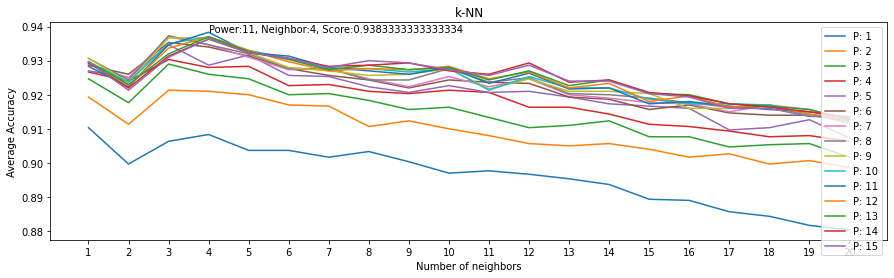

In [13]:
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
bp, bn, bs = 0, 0, 0
for p in n_powers:
    results = []
    distances = distance.pdist(X_train_small, 'minkowski', p)
    distances = distance.squareform(distances)
    for k in k_neighbors:
        print(f'Start validation: P:{p}, K:{k}')
        acc = leave_one_out(X_train_small, y_train_small, k, p, distances)
        if bs < acc: bp, bn, bs = p, k, acc
        results.append(acc)
        print(f"Finished, mean accuracy: {acc:.3%}")
    plt.plot(k_neighbors, results, label=f'P: {p}')
        
plt.text(bn, bs, f'Power:{bp}, Neighbor:{bn}, Score:{bs}')
plt.legend()
plt.show()

## Critical thinking: Comparison between two method by using or not using pre-caculated distance

In [147]:
acc = mean(cross_val_score(X_train_small, y_train_small, cv= 5, k=20, p=2))
print(acc)

0.8926666666666667


In [80]:
distances = distance.cdist(X_train_small, X_train_small, 'minkowski', 2)
# distances = distance.squareform(distances)

In [146]:
acc = mean(new_cross_val_score(X_train_small, y_train_small, distances, cv=5, k=3, p=2))
print(acc)

0.8926666666666667


In [196]:
acc = mean(new_new_cross_val_score(X_train_small, y_train_small, distances, cv=5, k=3, p=2))
print(acc)

0.9193333333333333


we assume that the distance computation takes much time, even though in theory, there's no difference between the two methods. Hence, we test the time of distance computation below.

In [77]:
def computeDistances(data, cv=5, p=2):
    fold_size = int(data.shape[0]/cv)
    indices = np.arange(data.shape[0])
    np.random.RandomState(123).shuffle(indices)
    for i in range(cv):
        validation_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        distance.cdist(X_train_small[validation_idx], X_train_small[train_idx],'minkowski', 2)
    

In [78]:
computeDistances(X_train_small, cv = X_train_small.shape[0],p = 2)

The reason that the old method is faster when cv = 5, is that

## d.Improve performance of k-NN by data preprocessing

In [18]:
from scipy.stats import norm
import math
from sklearn import preprocessing
def get_nth_quartile(data, n):  
    if n < 1 or n > 3:
        return false
    data.sort()
    position = 1 + (len(data)-1)*n/4
    pos_integer = int(math.modf(position)[1])
    pos_decimal = position - pos_integer
    quartile = data[pos_integer - 1] + (data[pos_integer] - data[pos_integer - 1])*pos_decimal
    return quartile

def min_max_scaling(data):
    return np.where(data.ptp(0) == 0, data, (data - data.min(0)) / data.ptp(0))

def standard_scaling(data):
    return preprocessing.normalize(data)

def max_abs_scaling(data):
    return np.where(abs(data.max(0)) == 0, data, data / abs(data.max(0)))

def robust_scaling(data):
#     return RobustScaler().fit(data).transform(data)
    temp=data.copy()
    tmp = data.copy()
    for i in range(len(tmp)):
        quartile=get_nth_quartile(tmp[i],1)
        quartiletre=get_nth_quartile(tmp[i],3)
        median=get_nth_quartile(tmp[i],2)
        if quartiletre-quartile != 0:
            temp[i]=[((temp[i][j] - median) / (quartiletre-quartile)) for j in range(len(temp[i]))]
    return temp

def unit_scaling(data):
    temp=np.ndarray(data.shape)
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] != 0:
                temp[i][j]=1
    return temp


In [20]:
X_train_mm = min_max_scaling(X_train_small)
X_test_mm = min_max_scaling(X_test_small)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [21]:
X_train_ma = max_abs_scaling(X_train_small)
X_test_ma = max_abs_scaling(X_test_small)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [22]:
X_train_nr = standard_scaling(X_train_small)
X_test_nr = standard_scaling(X_test_small)

In [23]:
X_train_rs = robust_scaling(X_train_small)
X_test_rs = robust_scaling(X_test_small)

In [29]:
X_train_unit = unit_scaling(X_train_small)
X_test_unit = unit_scaling(X_test_small)

In [31]:
k_neighbors = np.linspace(1, 5, 5, dtype='int')
distances_mm = distance.pdist(X_train_mm, 'minkowski', 2)
distances_mm = distance.squareform(distances_mm)

distances_ma = distance.pdist(X_train_ma, 'minkowski', 2)
distances_ma = distance.squareform(distances_ma)

distances_nr = distance.pdist(X_train_nr, 'minkowski', 2)
distances_nr = distance.squareform(distances_nr)

In [32]:
distances_rs = distance.pdist(X_train_rs, 'minkowski', 2)
distances_rs = distance.squareform(distances_rs)

In [33]:
distances_unit = distance.pdist(X_train_unit, 'minkowski', 2)
distances_unit = distance.squareform(distances_unit)

In [34]:
k_neighbors = np.linspace(1, 20, 20, dtype='int')

start validate 1  neighbors
mm finished
start validate 2  neighbors
mm finished
start validate 3  neighbors
mm finished
start validate 4  neighbors
mm finished
start validate 5  neighbors
mm finished
start validate 6  neighbors
mm finished
start validate 7  neighbors
mm finished
start validate 8  neighbors
mm finished
start validate 9  neighbors
mm finished
start validate 10  neighbors
mm finished
start validate 11  neighbors
mm finished
start validate 12  neighbors
mm finished
start validate 13  neighbors
mm finished
start validate 14  neighbors
mm finished
start validate 15  neighbors
mm finished
start validate 16  neighbors
mm finished
start validate 17  neighbors
mm finished
start validate 18  neighbors
mm finished
start validate 19  neighbors
mm finished
start validate 20  neighbors
mm finished


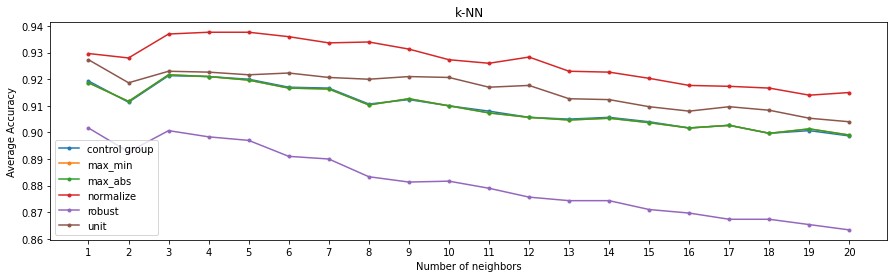

In [198]:
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
knn0 = []
knn1 = []
knn2 = []
knn3 = []
knn4 = []
knn5 = []


for k in k_neighbors:
    print("start validate", k," neighbors")
    # k-fold cv from scratch for k-NN
    acc0 = mean(new_cross_val_score(X_train_small,y_train_small,distances, cv=y_train_small.shape[0], k=k, p=2))
    acc1 = mean(new_cross_val_score(X_train_mm,y_train_small,distances_mm, cv=y_train_small.shape[0], k=k, p=2))
    print("mm finished")
    acc2 = mean(new_cross_val_score(X_train_ma,y_train_small,distances_ma, cv=y_train_small.shape[0], k=k, p=2))
    acc3 = mean(new_cross_val_score(X_train_nr,y_train_small,distances_nr, cv=y_train_small.shape[0], k=k, p=2))
    acc4 = mean(new_cross_val_score(X_train_rs,y_train_small,distances_rs, cv=y_train_small.shape[0], k=k, p=2))
    acc5 = mean(new_cross_val_score(X_train_unit,y_train_small,distances_unit, cv=y_train_small.shape[0], k=k, p=2))
    knn0.append(acc0)
    knn1.append(acc1)
    knn2.append(acc2)
    knn3.append(acc3)
    knn4.append(acc4)
    knn5.append(acc5)

plt.plot(k_neighbors, knn0, label="control group",marker='.')
plt.plot(k_neighbors, knn1, label="max_min",marker='.')
plt.plot(k_neighbors, knn2, label="max_abs",marker='.')
plt.plot(k_neighbors, knn3, label="normalize",marker='.')
plt.plot(k_neighbors, knn4, label="robust",marker='.')
plt.plot(k_neighbors, knn5, label="unit",marker='.')
plt.legend()
plt.show()

## PCA: Dimensionality Reduction

In [38]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_small)
X_test_pca = pca.transform(X_test_small)
# X_train_pca = pca.fit_transform(train_small[:,1:])
# X_test_pca = pca.transform(test_small[:,1:])

In [39]:
n_components = np.linspace(5,50,10, dtype='int')
k_neighbors = np.linspace(1,7,7, dtype='int')

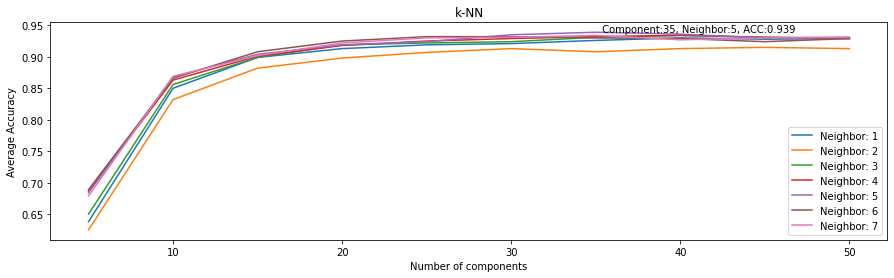

In [40]:
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xlabel("Number of components")
plt.ylabel("Average Accuracy")
bc, bn, bs = 0, 0, 0
for k in k_neighbors:
    knn = []
    for n_component in n_components:
        KNN = KNearestNeighbors(k, 2)
        KNN.fit(X_train_pca[:,:n_component], train_small[:,0])
        y_pred = KNN.predict(X_test_pca[:,:n_component])
        score = sum(y_pred==test_small[:,0])/test_small[:,0].shape[0]
        if score > bs:
            bc, bn, bs = n_component, k, score
        knn.append(score)
    plt.plot(n_components, knn, label=f'Neighbor: {k}')
plt.text(bc, bs,f"  Component:{bc}, Neighbor:{bn}, ACC:{bs}")
plt.legend()
plt.show()

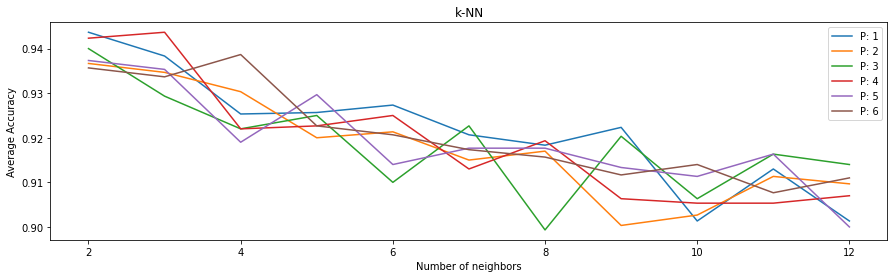

In [116]:
random.seed(1)
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
for p in range(1, 7):
    knn = []
    for k in range(2, 13):
        # k-fold cv from scratch for k-NN
        acc = mean(cross_val_score(train_small, cv=12, k=k, p=p))
        knn.append(acc)
    plt.plot(range(2, 13), knn, label=f'P: {p}')
plt.legend()
plt.show()
#         print(f'Accuracy: {acc:.3f}, K: {k}, P: {p}')
# plt.figure(figsize = (15, 4))
# plt.title("k-NN")
# plt.xlabel("Number of neighbors")
# plt.ylabel("Average Accuracy")
# plt.plot(range(2, 13), knn);